In [1]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim

from utils.datasets import get_mnist, get_images_for_class, generate_mean_image_for_class, get_random_image
from utils.utils import show_examples, imshow, show_neighbors, show_dataset_examples
from utils.models import SeparableCNN, DeConvNet
from utils.train import train_separable_cnn, save, validate_separable_cnn, load


In [2]:
model_name = 'model_deconv.pt'

# I. Preparation
Steps 1-4. allow for the creation and saving of a simple CNN model for digit recognition based on the MNIST dataset. **Skip to step 5 for the loading of a model, if such is available.**

## 1. Load and display the dataset

In [3]:
trainset, trainloader, testset, testloader = get_mnist()

    6     3     0     9


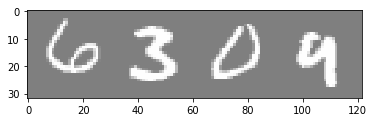

In [4]:
show_dataset_examples(trainloader)

## 2. Create the model

In [5]:
model = SeparableCNN()
print(model)

SeparableCNN(
  (base): CNNBase(
    (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
    (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): CNNClassifier(
    (fc1): Linear(in_features=320, out_features=50, bias=True)
    (fc2): Linear(in_features=50, out_features=10, bias=True)
  )
)


## 3. Train and validate the model

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.07, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [7]:
train_separable_cnn(model, criterion, optimizer, trainloader, 5)

Epoch: 1	Batch: 300	Loss: 1.286	Accuracy: 0.953
Epoch: 1	Batch: 600	Loss: 0.439	Accuracy: 0.953
Epoch: 1	Batch: 900	Loss: 0.405	Accuracy: 1.000
Epoch: 1	Batch: 938	Loss: 0.068	Accuracy: 1.000
Epoch: 2	Batch: 300	Loss: 0.337	Accuracy: 1.000
Epoch: 2	Batch: 600	Loss: 0.320	Accuracy: 0.984
Epoch: 2	Batch: 900	Loss: 0.318	Accuracy: 0.969
Epoch: 2	Batch: 938	Loss: 0.084	Accuracy: 1.000
Epoch: 3	Batch: 300	Loss: 0.291	Accuracy: 1.000
Epoch: 3	Batch: 600	Loss: 0.288	Accuracy: 1.000
Epoch: 3	Batch: 900	Loss: 0.319	Accuracy: 0.984
Epoch: 3	Batch: 938	Loss: 0.059	Accuracy: 1.000
Epoch: 4	Batch: 300	Loss: 0.222	Accuracy: 0.984
Epoch: 4	Batch: 600	Loss: 0.275	Accuracy: 1.000
Epoch: 4	Batch: 900	Loss: 0.316	Accuracy: 1.000
Epoch: 4	Batch: 938	Loss: 0.054	Accuracy: 0.969
Epoch: 5	Batch: 300	Loss: 0.218	Accuracy: 0.984
Epoch: 5	Batch: 600	Loss: 0.301	Accuracy: 1.000
Epoch: 5	Batch: 900	Loss: 0.272	Accuracy: 1.000
Epoch: 5	Batch: 938	Loss: 0.088	Accuracy: 0.969
Finished Training


In [8]:
validate_separable_cnn(model, criterion, testloader)

Test loss: 0.058


## 4. Save the model

In [9]:
save(model, model_name)

## 5. Load the model

In [6]:
model = SeparableCNN()
model = load(model, model_name)

# II. DeConvNet

In [7]:
def run_deconv(model, deconv_model, image, show=True):
    x, first_idxs, second_idxs = model.base(image)

    result = deconv_model(x, second_idxs, first_idxs)
    
    # Normalize photo
    result = result.detach()
    result = (result - result.min()) / (result.max() - result.min())
    image = (image - image.min()) / (image.max() - image.min())
    
    if show:
        images = torch.zeros((2, 1, 28, 28))
        images[0] = image
        images[1] = result.detach()

        imshow(torchvision.utils.make_grid(images))
    
    return result

## 1. DeConvNet with all feature maps

In [32]:
deconv_model = DeConvNet()

# Load the weights from the trained base model
deconv_model.deconv1.weight = model.base.conv2.weight
deconv_model.deconv2.weight = model.base.conv1.weight

torch.Size([1, 20, 4, 4])


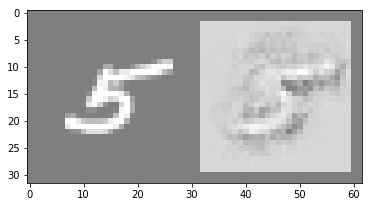

torch.Size([1, 20, 4, 4])


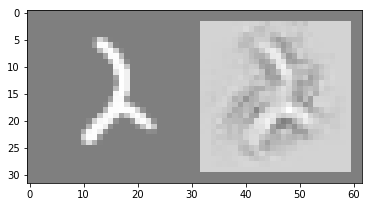

torch.Size([1, 20, 4, 4])


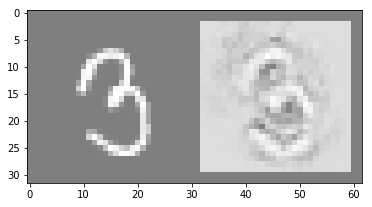

torch.Size([1, 20, 4, 4])


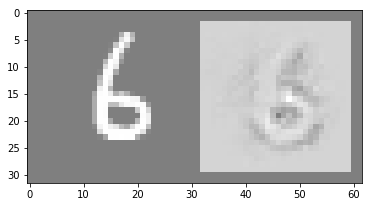

torch.Size([1, 20, 4, 4])


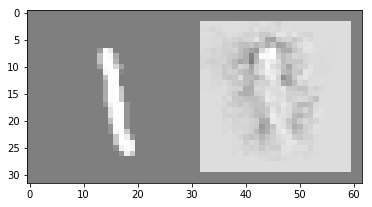

In [33]:
for i in range(5):
    img, label = get_random_image(trainloader)
    run_deconv(model, deconv_model, img)

## 2. DeConvNet with selected feature maps

Input Image:


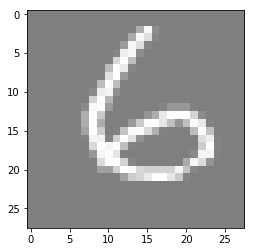

Results for the first CONV layer


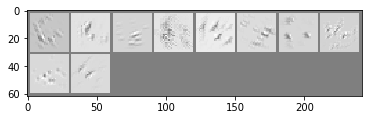

Results for the second CONV layer


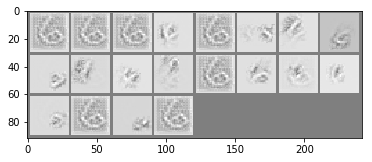

In [12]:
deconv_model = DeConvNet()

# Load the weights from the trained base model
deconv_model.deconv1.weight = model.base.conv2.weight
deconv_model.deconv2.weight = model.base.conv1.weight

# Generate a random image
img, label = get_random_image(trainloader)
print("Input Image:")
show_examples(img)

# Plot the results by iteratively setting all but one filters from
# the first CONV layer to zero.
first_weights = model.base.conv1.weight
images = torch.zeros(10, 1, 28, 28)
for i in range(10):
    new_weights = torch.zeros(first_weights.size())
    new_weights[i] = model.base.conv1.weight[i]
    deconv_model.deconv2.weight = torch.nn.Parameter(new_weights)
    
    images[i] = run_deconv(model, deconv_model, img, False)

print("Results for the first CONV layer")
show_examples(images)

# Plot the results by iteratively setting all but one filters from
# the second CONV layer to zero.
deconv_model.deconv2.weight = model.base.conv1.weight
second_weights = model.base.conv2.weight
images = torch.zeros(20, 1, 28, 28)
for i in range(20):
    new_weights = torch.zeros(second_weights.size())
    new_weights[i] = model.base.conv2.weight[i]
    deconv_model.deconv1.weight = torch.nn.Parameter(new_weights)
    
    images[i] = run_deconv(model, deconv_model, img, False)

print("Results for the second CONV layer")
show_examples(images)

# Occlusion Sensitivity

Input Image:


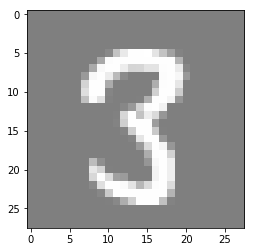

[99.99510049819946, 99.99672174453735, 99.88740086555481, 99.9448835849762]


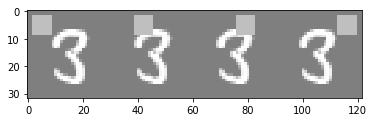

[99.95952248573303, 0.1761123538017273, 98.79514575004578, 99.4920551776886]


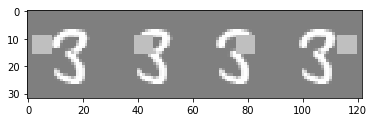

[99.98477697372437, 1.6945209354162216, 98.2446551322937, 99.51463341712952]


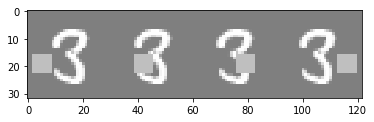

[99.99586343765259, 99.98852014541626, 99.9360978603363, 99.9213695526123]


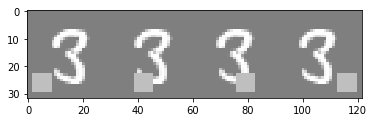

In [53]:
# Generate a random image
img, label = get_random_image(trainloader)
print("Input Image:")
show_examples(img)

jump = 7
for row in range(4):
    images = torch.zeros(4, 1, 28, 28)
    probabilities = []
    for column in range(4):
        new_image = img.clone().detach()
        new_image[0][0][row * jump: (row + 1) * jump, column * jump: (column + 1) * jump] = 0.5
        images[column] = new_image
        
        scores, _, _ = model(new_image)
        probabilities.append(torch.nn.functional.softmax(scores, dim=1).detach().numpy()[0][label] * 100)
        
    print(probabilities)
    show_examples(images)
        